<a href="https://colab.research.google.com/github/imation5212/Auot-regressive-Integrated-Moving-Average-ARIMA-/blob/main/ARIMA_Energy_Forecast_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Reading the input data
#df = pd.read_excel('Load_Set.xlsx')
df_energy_load = pd.read_excel('Thesis_data.xlsx')

# Formating to datetime
df_energy_load['DateTime'] = pd.to_datetime(df_energy_load['DateTime'],format='%Y-%m-%dT%H:%M:%SZ')
df_energy_load = df_energy_load.set_index('DateTime')
df_energy_load = df_energy_load.asfreq('30min')
# Sorting the values
df_energy_load.sort_values('DateTime', inplace=True)
def create_features(Kenya):
    """
    create time series features based on time series index.
    """
    Kenya["hour"] = Kenya.index.hour
    Kenya["dayofweek"] = Kenya.index.day_of_week
    Kenya["month"] = Kenya.index.month
    return Kenya
df_energy_load = create_features(df_energy_load)

# Aggregating in 1Hour intervals
# ==============================================================================
# The Date column is eliminated so that it does not generate an error when aggregating.
# The Holiday column does not generate an error since it is Boolean and is treated as 0-1.
#df_energy_load = df_energy_load.resample(rule='H', closed='left', label ='right').max()
df_energy_load = df_energy_load.resample(rule='H').max()
df_energy_load.index.freq
print(df_energy_load)
# Verify that a temporary index is complete
# ==============================================================================
print((df_energy_load.index == pd.date_range(start=df_energy_load.index.min(),
                              end=df_energy_load.index.max(),
                              freq=df_energy_load.index.freq)).all())

                              MW  Holiday  hour  dayofweek  month
DateTime                                                         
2018-01-01 00:00:00   959.150417     True     0          0      1
2018-01-01 01:00:00   913.192417     True     1          0      1
2018-01-01 02:00:00   861.146417     True     2          0      1
2018-01-01 03:00:00   829.476417     True     3          0      1
2018-01-01 04:00:00   804.144417     True     4          0      1
...                          ...      ...   ...        ...    ...
2022-12-31 20:00:00  1807.017954    False    20          5     12
2022-12-31 21:00:00  1739.585954    False    21          5     12
2022-12-31 22:00:00  1604.933954    False    22          5     12
2022-12-31 23:00:00  1453.867954    False    23          5     12
2023-01-01 00:00:00  1272.067954     True     0          6      1

[43825 rows x 5 columns]
True


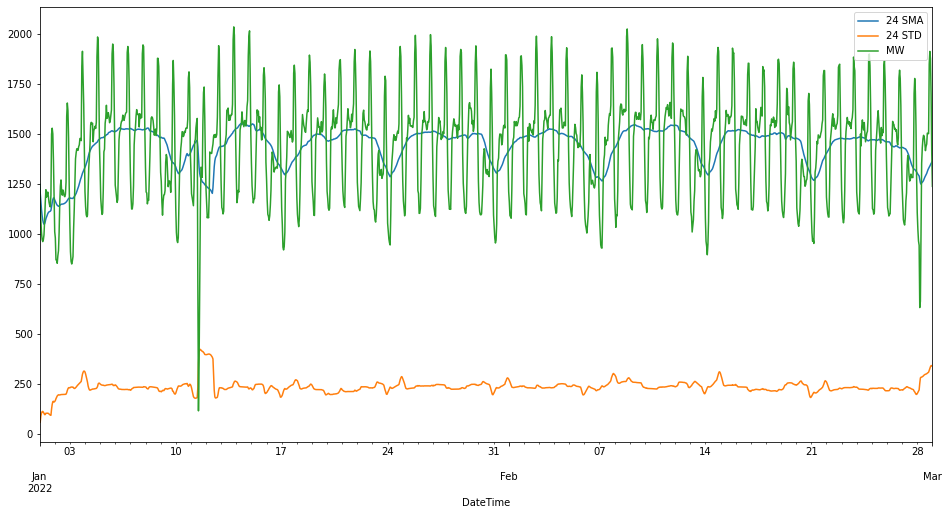

In [3]:
zoom = ('2022-01-01 00:00:00','2022-03-01 00:00:00')
# The simple moving average over a period of 12hours
#df_energy_load.loc[zoom[0]:zoom[1]].MW.rolling(12, min_periods=1).mean().plot(label='12 SMA',figsize=(16,8))
#df_energy_load.loc[zoom[0]:zoom[1]].MW.rolling(12,min_periods=1).std().plot(label='12 STD')

df_energy_load.loc[zoom[0]:zoom[1]].MW.rolling(24, min_periods=1).mean().plot(label='24 SMA',figsize=(16,8))
df_energy_load.loc[zoom[0]:zoom[1]].MW.rolling(24,min_periods=1).std().plot(label='24 STD')

df_energy_load.loc[zoom[0]:zoom[1]].MW.plot()
plt.legend()

In [4]:
def test_p_value(data):
  fuller_test=adfuller(data, autolag= "AIC")
  print(f'p-value: {fuller_test[1]}')

  if fuller_test[1] > 0.05:
    print('Do not reject null hbypothesis, Series is not Stationary')
  else:
    print('Reject null hypothesis, Series is Stationary')

In [5]:
test_p_value(df_energy_load['MW'])

p-value: 0.0
Reject null hypothesis, Series is Stationary


#**For non stationary data, differencing will need to be implemented to make the data stationary. Differencing process is of three types:**
> First differencing; Formula used is as follows:
>>***data['first_differencing'] = data[y_value_to_be_forecasted] - data[y_value_to_be_forecasted].shift(1)*** i.e. df_energy_load['first_differencing'] = df_energy_load['MW'] - df_energy_load['MW'].shift(1)

>Second differencing; Formula used is as follows:
>>***data['second_differencing'] = data['first_differencing'] - data['first_differencing'].shift(1)*** i.e. df_energy_load['second_differencing'] = df_energy_load['first_differencing'] - df_energy_load['first_differencing'].shift(1)

>Seasonal Differencing; Formula used is as follows:
>>***data['seasonal_differencing'] = data['y_value_to_be_forecasted'] - data['y_value_to_be_forecasted'].shift(lag_to_be_used)*** i.e. df_energy_load['seasonal_differencing'] = df_energy_load['MW'] - df_energy_load['MW'].shift(24)



#***Model1 Is A SARIMAX Model***

In [6]:
model1=sm.tsa.statespace.SARIMAX(df_energy_load['MW'],order=(0,0,0),seasonal_order=(1,0,1,24))
results1=model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                         MW   No. Observations:                43825
Model:             SARIMAX(1, 0, [1], 24)   Log Likelihood             -268471.072
Date:                    Thu, 12 Jan 2023   AIC                         536948.145
Time:                            15:11:09   BIC                         536974.209
Sample:                        01-01-2018   HQIC                        536956.360
                             - 01-01-2023                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9998   2.13e-05    4.7e+04      0.000       1.000       1.000
ma.S.L24      -0.9114      0.002   -497.074      0.000      -0.915      -0.908
sigma2      1.225e+04     43.060    284.502      0.000    1.22e+04    1.23e+04
===================================================================================
Ljung-Box (L1) (Q):               39032.03   Jarque-Bera (JB):             95081.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -1.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
results1.resid

DateTime
2018-01-01 00:00:00    959.150417
2018-01-01 01:00:00    913.192531
2018-01-01 02:00:00    861.146573
2018-01-01 03:00:00    829.476566
2018-01-01 04:00:00    804.144559
                          ...    
2022-12-31 20:00:00    -62.722379
2022-12-31 21:00:00    -66.888166
2022-12-31 22:00:00    -62.933212
2022-12-31 23:00:00     -3.708678
2023-01-01 00:00:00    -13.198555
Freq: H, Length: 43825, dtype: float64

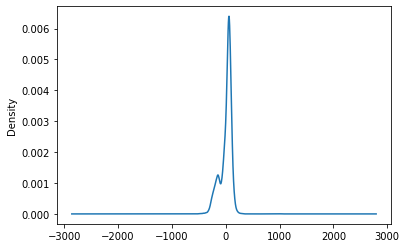

In [8]:
results1.resid.plot(kind='kde')

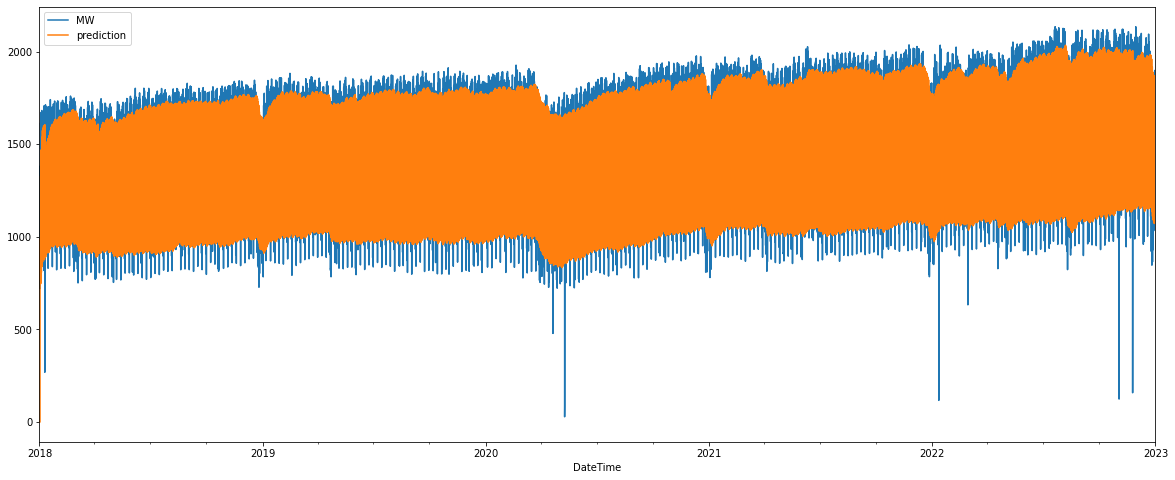

In [11]:
# Insample Forecasting
df_energy_load['prediction']=results1.predict()
df_energy_load[['MW','prediction']].plot(figsize=(20,8))

In [ ]:
# Out-of-sample Forecasting
from pandas.tseries.offsets import DateOffset
extra_dates=[df_energy_load.index[-1] + DateOffset()]

#***Model2 Is A ARIMA Model***

In [ ]:
model2=ARIMA(df_energy_load['MW'],order=(24,0,1))
results2=model2.fit()
results2.summary()
